In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from scipy.special import binom 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
from torch.autograd import Variable
import torch.utils.data as data_utils
import torch.nn.init as init

from collections import Counter
import operator
import copy 
from itertools import product,combinations
from time import time 
#from IPython.core.display import display

%matplotlib inline

## code extracted from https://www.kaggle.com/code/graymant/breast-cancer-diagnosis-with-pytorch
## SV code extracted from https://github.com/mburaksayici/ExplainableAI-Pure-Numpy/blob/main/KernelSHAP-Pure-Numpy.ipynb

In [253]:
# SHAP kernel 

class SHAP_kernel(object): 
    def __init__(self,n_clients,samples,verbose=True):
        self.samples = samples 
        self.n_clients = n_clients 
        self.verbose = verbose 
        self.indices = []
        
    def first_guess(self): 
        self.shap_weights = [(self.n_clients-1)/(z*(self.n_clients-z)) for z in list(range(1,self.n_clients))]
        self.discrete_shap = np.round(self.shap_weights/np.sum(self.shap_weights)*self.samples)
        
    def adjust_if_necessary(self,shap_kernel):
        ddd = copy.copy(shap_kernel)
        
        self.changed = False 
        for i,ele in enumerate(shap_kernel):
            if i not in self.indices: 
                binom_i = binom(len(shap_kernel)+1,i+1)
                if binom_i < ele: 
                    self.changed = True 
                    ddd[i] = binom_i
                    self.indices.append(i)
        #print(ddd)
        if self.changed == True: 
            n = self.samples - np.sum(ddd)
            p = np.sum(ddd) - np.sum(ddd[self.indices])
            if p != 0: 
                self.adjusted = np.round(ddd * (n+p)/p)
                self.adjusted[self.indices] = ddd[self.indices]
            else: 
                self.adjusted = ddd 
                #self.changed = False

    def weights(self):
        
        if self.changed == True: 
            while self.changed == True: 
                shap.adjust_if_necessary(self.adjusted)
                
            weights = (1/len(self.discrete_shap))*np.ones(np.shape(self.discrete_shap))
            changes = self.discrete_shap/self.adjusted
            weights = weights*changes 
            self.weights = weights / np.sum(weights)
            if self.verbose == True: 
                fig,ax = plt.subplots(2,2)
                plt.tight_layout()
                ax[0,0].plot(np.arange(1,self.n_clients),self.adjusted)
                ax[0,0].title.set_text("number of coalitions with k clients")
                ax[0,1].plot(np.arange(1,self.n_clients),weights)
                ax[0,1].title.set_text("weights")
                ax[1,0].plot(np.arange(1,self.n_clients),self.adjusted*weights)
                ax[1,0].title.set_text("# coalitions * weights")
                ax[1,1].plot(np.arange(1,self.n_clients),self.shap_weights)
                ax[1,1].title.set_text("exact Shapley kernel")
                
                print("weights: ",weights)
                print("we took: ",int(np.sum(self.adjusted))," samples instead of ",self.samples," samples")
                print(np.sum(weights))
        else: 
            # uniform weights 
            self.weights = (1/len(self.discrete_shap))*np.ones(np.shape(self.discrete_shap))
            if self.verbose == True: 
                print("weights: ",weights)
                plt.plot(self.discrete_shap*weights)
                print("we took: ",int(np.sum(self.discrete_shap))," samples instead of ",self.samples," samples")
        
    def forward(self): 
        self.first_guess()
        self.adjust_if_necessary(shap_kernel=self.discrete_shap)
        self.weights()

class create_coalitions(object):
    def __init__(self,discrete_shap,weights,n_clients):
        self.actual_samples = int(np.sum(discrete_shap))
        self.discrete_shap = discrete_shap
        self.weights = weights 
        self.n_clients = n_clients 

    def combiner(self,used_masks,i_old,zeros=3,ones=2):
        for i,indices in enumerate(combinations(range(zeros+ones),ones)):
            item = ['0']*(zeros+ones)
            for index in indices: 
                item[index] = '1'
            used_masks[''.join(item)] = int(i_old + i +1)

    # determine the permutation length weighted by SV 
    def permutation_length(self): 
        arr = np.zeros(self.actual_samples)
        K_old = 0 
        for i,K in enumerate(self.discrete_shap): 
            arr[int(K_old):int(K+K_old)] = int(i)
            K_old += K 
        #np.random.shuffle(arr)
        return arr
    
    def forward(self): 
        indices = self.permutation_length()

        mask = np.zeros(n_clients)
        used_masks = {}
        kernel_weights = {}
        full_clients = []
        number_masks = 0 
        for i in range(self.actual_samples):
            mask.fill(0.0)

            ind = indices[i] + 1
            kernel_weights[i] = self.weights[int(indices[i])]
            if binom(n_clients,ind) <= self.discrete_shap[int(indices[i])]:
                # list all permutations. 
                if ind not in full_clients: 
                    full_clients.append(ind)
                    self.combiner(used_masks,number_masks,self.n_clients-int(ind),int(ind))
                    number_masks += binom(self.n_clients,ind)

            else: 

                number_masks_after = number_masks + 1 
                time_before = time()
                while number_masks != number_masks_after: 
                    mask.fill(0.0)
                    perm = np.random.permutation(self.n_clients)[:int(ind)]
                    mask[perm] = 1
                    tuple_m = ''.join(str(int(x)) for x in mask)
                    if tuple_m not in used_masks: 
                        used_masks[tuple_m] = int(number_masks)
                        number_masks += 1 
                    time_int = time()
                    if time_int > time_before + 0.05: 
                        print("failed to find all permutations")
                        break
                        
        masks = np.zeros((self.actual_samples,self.n_clients))
        weights = np.zeros(self.actual_samples)
        for i,coalition in enumerate(used_masks.keys()):
            masks[i,:] = np.array(list(coalition))#int(coalition,2)
            weights[i] = kernel_weights[i]
        weights = weights / np.sum(weights)
        return masks,weights
                        
#coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
#masks,weights = coalition_object.forward()
#print(masks)
#print(weights)

weights:  [0.13563218 0.02731751 0.02732596 0.0270936  0.02738337 0.02758621
 0.02681992 0.02729885 0.02698651 0.02664577 0.02758621 0.02758621
 0.02722323 0.02722323 0.02722323 0.02722323 0.02722323 0.02758621
 0.02758621 0.02664577 0.02698651 0.02729885 0.02681992 0.02758621
 0.02738337 0.0270936  0.02732596 0.02731751 0.13563218]
we took:  899  samples instead of  900  samples
1.0066407249553877
[30. 77. 53. 42. 34. 30. 27. 24. 23. 22. 20. 20. 19. 19. 19. 19. 19. 20.
 20. 22. 23. 24. 27. 30. 34. 42. 53. 77. 30.]
[0.13473743 0.0271373  0.02714569 0.02691486 0.02720272 0.02740422
 0.02664299 0.02711876 0.02680848 0.02646999 0.02740422 0.02740422
 0.02704364 0.02704364 0.02704364 0.02704364 0.02704364 0.02740422
 0.02740422 0.02646999 0.02680848 0.02711876 0.02664299 0.02740422
 0.02720272 0.02691486 0.02714569 0.0271373  0.13473743]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
0.0043752317389692255


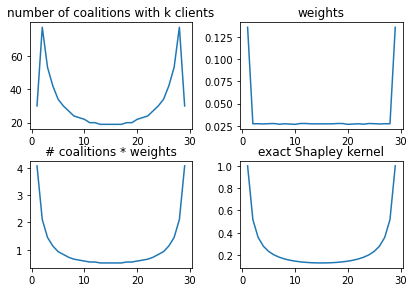

In [254]:
n_clients = 30
shap = SHAP_kernel(n_clients,900,verbose=True)
shap.forward()
print(shap.adjusted)
print(shap.weights)
discrete_shap = shap.adjusted

coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
masks,weights = coalition_object.forward()
print(masks[0])
print(weights[0])

In [121]:
print(instance_to_explain)
print(np.shape(x))

tensor([-0.4081, -0.8766, -0.8008,  0.0956, -0.1187, -0.4710, -0.5666, -0.7301,
         0.3863, -0.8411])
(455, 10)


In [92]:
print(explainer.maskMatrix)
print(explainer.kernelWeights)
print(np.shape(explainer.maskMatrix))
print(np.shape(explainer.kernelWeights))


print(masks)
print(weights)
print(np.shape(masks))
print(np.shape(weights))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [1. 0. 1.

In [263]:
# Load breast cancer data and print its shape
data = load_breast_cancer()

# Standardize dataset, split in train/test and load it into Torch dataloader
x_train, x_test, y_train, y_test = train_test_split(data.data[:,:(n_clients+1)], data.target, test_size=0.2, random_state=85)
print(np.shape(x_train))
scaler = StandardScaler()
transformed = scaler.fit_transform(x_train)

train = data_utils.TensorDataset(torch.from_numpy(transformed).float(),
                                 torch.from_numpy(y_train).float())
dataloader = data_utils.DataLoader(train, batch_size=128, shuffle=False)
scaler = StandardScaler()
transformed = scaler.fit_transform(x_test)

test_set = torch.from_numpy(transformed).float()
test_valid = torch.from_numpy(y_test).float()

(455, 30)


In [37]:
def create_model(layer_dims):
    model = torch.nn.Sequential()
    for idx, dim in enumerate(layer_dims):
        if (idx < len(layer_dims) - 1):
            module = torch.nn.Linear(dim, layer_dims[idx + 1])
            init.xavier_normal(module.weight)
            model.add_module("linear" + str(idx), module)
        else:
            model.add_module("sig" + str(idx), torch.nn.Sigmoid())
        if (idx < len(layer_dims) - 2):
            model.add_module("relu" + str(idx), torch.nn.ReLU())

    return model

In [264]:
## Create model and hyper parameters
dim_in = x_train.shape[1]
dim_out = 1

layer_dims = [dim_in, 20, 10, dim_out]

model = create_model(layer_dims)

loss_fn = torch.nn.MSELoss(size_average=False)
learning_rate = 0.0007
n_epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Now run model
history = { "loss": [], "accuracy": [], "loss_val": [], "accuracy_val": [] }
for epoch in range(n_epochs):
    loss = None

    for idx, (minibatch, target) in enumerate(dataloader):
        y_pred = model(Variable(minibatch))

        loss = loss_fn(y_pred, Variable(target.float()).unsqueeze(1))

        prediction = [1 if x > 0.5 else 0 for x in y_pred.data.numpy()]
        correct = (prediction == target.numpy()).sum()
        
        # This can be uncommented for a per mini batch feedback
        #history["loss"].append(loss.data[0])
        #history["accuracy"].append(100 * correct / len(prediction))
        
        y_val_pred = model(Variable(test_set))
        loss_val = loss_fn(y_val_pred, Variable(test_valid.float()).unsqueeze(1))
        prediction_val = [1 if x > 0.5 else 0 for x in y_val_pred.data.numpy()]
        correct_val = (prediction_val == test_valid.numpy()).sum()
        
        # This can be uncommented for a per mini batch feedback
        #history["loss_val"].append(loss_val.data[0])
        #history["accuracy_val"].append(100 * correct_val / len(prediction_val))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    history["loss"].append(loss.detach().cpu().numpy())
    history["accuracy"].append(100 * correct / len(prediction))
    history["loss_val"].append(loss_val.detach().cpu().numpy())
    history["accuracy_val"].append(100 * correct_val / len(prediction_val))
    print("Loss, accuracy, val loss, val acc at epoch", epoch + 1,history["loss"][-1], 
          history["accuracy"][-1], history["loss_val"][-1], history["accuracy_val"][-1] )


index, value = max(enumerate(history["accuracy_val"]), key=operator.itemgetter(1))

print("Best accuracy was {} at iteration {}".format(value, index))


/tmp/ipykernel_2976669/3960200099.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(module.weight)
/mimer/NOBACKUP/groups/snic2022-22-122/arthur/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Loss, accuracy, val loss, val acc at epoch 1 19.158373 36.61971830985915 31.878298 34.21052631578947
Loss, accuracy, val loss, val acc at epoch 2 18.222645 39.436619718309856 30.466404 39.473684210526315
Loss, accuracy, val loss, val acc at epoch 3 17.325396 49.29577464788732 29.109861 46.49122807017544
Loss, accuracy, val loss, val acc at epoch 4 16.484566 50.70422535211268 27.80089 52.63157894736842
Loss, accuracy, val loss, val acc at epoch 5 15.716959 59.15492957746479 26.539585 59.64912280701754
Loss, accuracy, val loss, val acc at epoch 6 14.976494 64.78873239436619 25.35872 67.54385964912281
Loss, accuracy, val loss, val acc at epoch 7 14.235081 74.64788732394366 24.221355 71.05263157894737
Loss, accuracy, val loss, val acc at epoch 8 13.514464 83.09859154929578 23.10157 78.0701754385965
Loss, accuracy, val loss, val acc at epoch 9 12.809391 90.14084507042253 21.964735 80.70175438596492
Loss, accuracy, val loss, val acc at epoch 10 12.115658 94.36619718309859 20.86991 84.2105263

Loss, accuracy, val loss, val acc at epoch 89 1.0926553 97.1830985915493 4.1036215 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 90 1.0801578 97.1830985915493 4.090623 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 91 1.0678415 97.1830985915493 4.0785193 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 92 1.0557848 97.1830985915493 4.06812 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 93 1.0438507 97.1830985915493 4.0588527 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 94 1.0321803 97.1830985915493 4.0504603 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 95 1.0206535 97.1830985915493 4.042772 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 96 1.0091146 97.1830985915493 4.035507 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 97 0.9975846 98.59154929577464 4.0285735 94.73684210526316
Loss, accuracy, val loss, val acc at epoch 98 0.9861414 98.59154929577464 4.0223775 94.73684210

Loss, accuracy, val loss, val acc at epoch 178 0.3076071 100.0 4.171808 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 179 0.30213076 100.0 4.1678953 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 180 0.29694882 100.0 4.1641555 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 181 0.29213315 100.0 4.161752 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 182 0.28753754 100.0 4.161072 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 183 0.28309658 100.0 4.1605177 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 184 0.2788837 100.0 4.1600475 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 185 0.27465558 100.0 4.158535 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 186 0.270135 100.0 4.1563225 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 187 0.26575187 100.0 4.154796 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 188 0.26170638 100.0 4.153658 96.4912280701754

Loss, accuracy, val loss, val acc at epoch 268 0.08820869 100.0 3.8101826 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 269 0.0873524 100.0 3.805632 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 270 0.08645023 100.0 3.8009522 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 271 0.085594915 100.0 3.796067 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 272 0.08476005 100.0 3.7910876 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 273 0.08394997 100.0 3.78595 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 274 0.08321138 100.0 3.7811432 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 275 0.08239749 100.0 3.7761428 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 276 0.081662506 100.0 3.7718463 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 277 0.0809075 100.0 3.767337 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 278 0.080098756 100.0 3.7618902 97.3684210

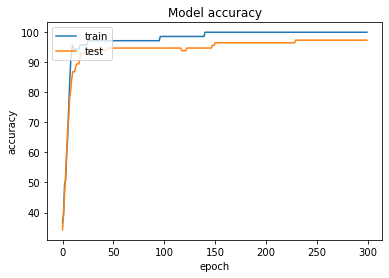

In [265]:
# Print the loss curves 
plt.plot(history['accuracy'])
plt.plot(history['accuracy_val'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [266]:
instance_to_explain = test_set[0,:] #.detach().cpu().numpy() #x_test[0]
print(instance_to_explain)
     
y_val_pred = model(Variable(instance_to_explain))
print(f"model score for the prediction to be explained: f{instance_to_explain}={y_val_pred[0]:.3f}")

x = scaler.fit_transform(x_train)




tensor([-0.9102, -0.4081, -0.8766, -0.8008,  0.0956, -0.1187, -0.4710, -0.5666,
        -0.7301,  0.3863, -0.8411,  0.6534, -0.7727, -0.5698,  0.5024,  0.3104,
         0.3529,  0.1498, -0.8948, -0.0774, -0.9539,  0.1766, -0.9011, -0.7920,
         0.6129,  0.0140, -0.2957, -0.2589, -0.9297,  0.0606])
model score for the prediction to be explained: ftensor([-0.9102, -0.4081, -0.8766, -0.8008,  0.0956, -0.1187, -0.4710, -0.5666,
        -0.7301,  0.3863, -0.8411,  0.6534, -0.7727, -0.5698,  0.5024,  0.3104,
         0.3529,  0.1498, -0.8948, -0.0774, -0.9539,  0.1766, -0.9011, -0.7920,
         0.6129,  0.0140, -0.2957, -0.2589, -0.9297,  0.0606])=1.000


In [267]:

class Data:
    def __init__(self):
        pass
    
class DenseData(Data):
    def __init__(self, data, group_names, *args):
        self.groups = args[0] if len(args) > 0 and args[0] is not None else [np.array([i]) for i in range(len(group_names))]

        l = sum(len(g) for g in self.groups)
        num_samples = data.shape[0]
        t = False
        if l != data.shape[1]:
            t = True
            num_samples = data.shape[1]

        valid = (not t and l == data.shape[1]) or (t and l == data.shape[0])
        assert valid, "# of names must match data matrix!"

        self.weights = args[1] if len(args) > 1 else np.ones(num_samples)
        self.weights /= np.sum(self.weights)
        wl = len(self.weights)
        valid = (not t and wl == data.shape[0]) or (t and wl == data.shape[1])
        assert valid, "# weights must match data matrix!"

        self.transposed = t
        self.group_names = group_names
        self.data = data
        self.groups_size = len(self.groups)
        
def convert_to_data(val, keep_index=False):
    if isinstance(val, Data):
        return val
    elif type(val) == np.ndarray:
        return DenseData(val, [str(i) for i in range(val.shape[1])])
    elif str(type(val)).endswith("'pandas.core.series.Series'>"):
        return DenseData(val.values.reshape((1,len(val))), list(val.index))
    elif str(type(val)).endswith("'pandas.core.frame.DataFrame'>"):
        if keep_index:
            return DenseDataWithIndex(val.values, list(val.columns), val.index.values, val.index.name)
        else:
            return DenseData(val.values, list(val.columns))
    ##elif sp.sparse.issparse(val):
    #    if not sp.sparse.isspmatrix_csr(val):
    #        val = val.tocsr()
     #   return SparseData(val)
    else:
        assert False, "Unknown type passed as data object: "+str(type(val))
        
class Model:
    def __init__(self, f, out_names):
        self.f = f
        self.out_names = out_names


def convert_to_model(val):
    if isinstance(val, Model):
        return val
    else:
        return Model(val, None)
    
def match_model_to_data(model, data):
    assert isinstance(model, Model), "model must be of type Model!"
    
    try:
        #if isinstance(data, DenseDataWithIndex):
        #    out_val = model.f(data.convert_to_df())
        #else:
        out_val = model.f(data.data)
    except:
        print("Provided model function fails when applied to the provided data set.")
        raise

    if model.out_names is None:
        if len(out_val.shape) == 1:
            model.out_names = ["output value"]
        else:
            model.out_names = ["output value "+str(i) for i in range(out_val.shape[0])]
    
    return out_val

class Instance:
    def __init__(self, x, group_display_values):
        self.x = x
        self.group_display_values = group_display_values


def convert_to_instance(val):
    if isinstance(val, Instance):
        return val
    else:
        return Instance(val, None)
    
def match_instance_to_data(instance, data):
    assert isinstance(instance, Instance), "instance must be of type Instance!"

    if isinstance(data, DenseData):
        if instance.group_display_values is None:
            instance.group_display_values = [instance.x[0, group[0]] if len(group) == 1 else "" for group in data.groups]
        assert len(instance.group_display_values) == len(data.groups)
        instance.groups = data.groups

In [268]:
import copy 
class Kernel(object):
    """Uses the Kernel SHAP method to explain the output of any function.
    Kernel SHAP is a method that uses a special weighted linear regression
    to compute the importance of each feature. The computed importance values
    are Shapley values from game theory and also coefficents from a local linear
    regression.
    Parameters
    ----------
    model : function or iml.Model
        User supplied function that takes a matrix of samples (# samples x # features) and
        computes a the output of the model for those samples. The output can be a vector
        (# samples) or a matrix (# samples x # model outputs).
    data : numpy.array or pandas.DataFrame or shap.common.DenseData or any scipy.sparse matrix
        The background dataset to use for integrating out features. To determine the impact
        of a feature, that feature is set to "missing" and the change in the model output
        is observed. Since most models aren't designed to handle arbitrary missing data at test
        time, we simulate "missing" by replacing the feature with the values it takes in the
        background dataset. So if the background dataset is a simple sample of all zeros, then
        we would approximate a feature being missing by setting it to zero. For small problems
        this background dataset can be the whole training set, but for larger problems consider
        using a single reference value or using the kmeans function to summarize the dataset.
        Note: for sparse case we accept any sparse matrix but convert to lil format for
        performance.
    link : "identity" or "logit"
        A generalized linear model link to connect the feature importance values to the model
        output. Since the feature importance values, phi, sum up to the model output, it often makes
        sense to connect them to the output with a link function where link(output) = sum(phi).
        If the model output is a probability then the LogitLink link function makes the feature
        importance values have log-odds units. ### Not relevant for us 
    Examples
    --------
    See :ref:`Kernel Explainer Examples <kernel_explainer_examples>`
    """

    def __init__(self, model, data, **kwargs):

        # convert incoming inputs to standardized iml objects
        self.model = convert_to_model(model)
        #self.model = model 
        self.keep_index = kwargs.get("keep_index", False)
        self.keep_index_ordered = kwargs.get("keep_index_ordered", False)
        #self.data = data 
        #model_null = self.model 
        self.data = convert_to_data(data, keep_index=self.keep_index)
        model_null = match_model_to_data(self.model, self.data)

        # warn users about large background data sets
        if len(self.data.weights) > 100:
            print("Using " + str(len(self.data.weights)) + " background data samples could cause " +
                        "slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to " +
                        "summarize the background as K samples.")

        # init our parameters
        self.N = self.data.data.shape[0]
        self.P = self.data.data.shape[1]
        self.nsamplesAdded = 0
        self.nsamplesRun = 0

        # find E_x[f(x)]
        if isinstance(model_null, (pd.DataFrame, pd.Series)):
            model_null = np.squeeze(model_null.values)
            model_null = model_null.numpy()
        self.fnull = np.sum((model_null.T * self.data.weights).T, 0)
        self.expected_value = self.fnull

        # see if we have a vector output
        self.vector_out = True
        if len(self.fnull.shape) == 0:
            self.vector_out = False
            self.fnull = np.array([self.fnull])
            self.D = 1
            self.expected_value = float(self.expected_value)
        else:
            self.D = self.fnull.shape[0]
            
    def varying_groups(self, x):
        varying_indices = []
        # go over all nonzero columns in background and evaluation data
        # if both background and evaluation are zero, the column does not vary
        varying_indices = np.unique(np.union1d(self.data.data.nonzero()[1], x.nonzero()[1]))
        remove_unvarying_indices = []
        for i in range(0, len(varying_indices)):
            varying_index = varying_indices[i]
            # now verify the nonzero values do vary
            data_rows = self.data.data[:, [varying_index]]
            nonzero_rows = data_rows.nonzero()[0]

            if nonzero_rows.size > 0:
                background_data_rows = data_rows[nonzero_rows]
                num_mismatches = np.sum(np.abs(background_data_rows - x[0, varying_index]) > 1e-7)
                # Note: If feature column non-zero but some background zero, can't remove index
                if num_mismatches == 0 and not \
                    (np.abs(x[0, [varying_index]][0, 0]) > 1e-7 and len(nonzero_rows) < data_rows.shape[0]):
                    remove_unvarying_indices.append(i)
        mask = np.ones(len(varying_indices), dtype=bool)
        mask[remove_unvarying_indices] = False
        varying_indices = varying_indices[mask]
        return varying_indices
            
    def allocate(self):
        self.synth_data = np.tile(self.data.data, (self.nsamples, 1))

        self.maskMatrix = np.zeros((self.nsamples, self.M))
        self.kernelWeights = np.zeros(self.nsamples)
        self.y = np.zeros((self.nsamples * self.N, self.D))
        self.ey = np.zeros((self.nsamples, self.D))
        self.lastMask = np.zeros(self.nsamples)
        self.nsamplesAdded = 0
        self.nsamplesRun = 0
        if self.keep_index:
            self.synth_data_index = np.tile(self.data.index_value, self.nsamples)
    def addsample(self, x, m, w):
        offset = self.nsamplesAdded * self.N
        if isinstance(self.varyingFeatureGroups, (list,)):
            for j in range(self.M):
                for k in self.varyingFeatureGroups[j]:
                    if m[j] == 1.0:
                        self.synth_data[offset:offset+self.N, k] = x[0, k]
        else:
            # for non-jagged numpy array we can significantly boost performance
            mask = m == 1.0
            groups = self.varyingFeatureGroups[mask]
            if len(groups.shape) == 2:
                for group in groups:
                    self.synth_data[offset:offset+self.N, group] = x[0, group]
            else:
                # further performance optimization in case each group has a single feature
                evaluation_data = x[0, groups]
                self.synth_data[offset:offset+self.N, groups] = evaluation_data
        self.maskMatrix[self.nsamplesAdded, :] = m
        self.kernelWeights[self.nsamplesAdded] = w
        self.nsamplesAdded += 1
        
    def addsample2(self, x, m):
        offset = self.nsamplesAdded * self.N
        if isinstance(self.varyingFeatureGroups, (list,)):
            for j in range(self.M):
                for k in self.varyingFeatureGroups[j]:
                    if m[j] == 1.0:
                        self.synth_data[offset:offset+self.N, k] = x[0, k]
        else:
            # for non-jagged numpy array we can significantly boost performance
            mask = m == 1.0
            groups = self.varyingFeatureGroups[mask]
            if len(groups.shape) == 2:
                for group in groups:
                    self.synth_data[offset:offset+self.N, group] = x[0, group]
            else:
                # further performance optimization in case each group has a single feature
                evaluation_data = x[0, groups]
                self.synth_data[offset:offset+self.N, groups] = evaluation_data
        self.maskMatrix[self.nsamplesAdded, :] = m
        self.nsamplesAdded += 1

    def shap_values(self, X, kernelshap=True,**kwargs):
        """ Estimate the SHAP values for a set of samples.
        Parameters
        ----------
        X : numpy.array or pandas.DataFrame or any scipy.sparse matrix
            A matrix of samples (# samples x # features) on which to explain the model's output.
        nsamples : "auto" or int
            Number of times to re-evaluate the model when explaining each prediction. More samples
            lead to lower variance estimates of the SHAP values. The "auto" setting uses
            `nsamples = 2 * X.shape[1] + 2048`.
        l1_reg : "num_features(int)", "auto" (default for now, but deprecated), "aic", "bic", or float
            The l1 regularization to use for feature selection (the estimation procedure is based on
            a debiased lasso). The auto option currently uses "aic" when less that 20% of the possible sample
            space is enumerated, otherwise it uses no regularization. THE BEHAVIOR OF "auto" WILL CHANGE
            in a future version to be based on num_features instead of AIC.
            The "aic" and "bic" options use the AIC and BIC rules for regularization.
            Using "num_features(int)" selects a fix number of top features. Passing a float directly sets the
            "alpha" parameter of the sklearn.linear_model.Lasso model used for feature selection.
            
        gc_collect : bool
           Run garbage collection after each explanation round. Sometime needed for memory intensive explanations (default False).
        Returns
        -------
        array or list
            For models with a single output this returns a matrix of SHAP values
            (# samples x # features). Each row sums to the difference between the model output for that
            sample and the expected value of the model output (which is stored as expected_value
            attribute of the explainer). For models with vector outputs this returns a list
            of such matrices, one for each output.
        """

        # convert dataframes
        if str(type(X)).endswith("pandas.core.series.Series'>"):
            X = X.values
        elif str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
            if self.keep_index:
                index_value = X.index.values
                index_name = X.index.name
                column_name = list(X.columns)
            X = X.values

        x_type = str(type(X))
        arr_type = "'numpy.ndarray'>"
        assert len(X.shape) == 1 or len(X.shape) == 2, "Instance must have 1 or 2 dimensions!"

        # single instance
        if len(X.shape) == 1:
            
            
            data = X.reshape((1, X.shape[0]))
            if self.keep_index:
                data = convert_to_instance_with_index(data, column_name, index_name, index_value)
            if kernelshap == True: 
                explanation = self.explain(data, **kwargs)
            else: 
                explanation = self.explain(data, kernelshap=kernelshap,weights=weights,masks=masks,nsamples=n_samples)

            # vector-output 
            s = explanation.shape
            if len(s) == 2:
                outs = [np.zeros(s[0]) for j in range(s[1])]
                for j in range(s[1]):
                    outs[j] = explanation[:, j]
                return outs

            # single-output
            else:
                out = np.zeros(s[0])
                out[:] = explanation
                return out

        # explain the whole dataset
        elif len(X.shape) == 2:
            print('shape is 2 ')
            breakpoint()
            explanations = []
            for i in tqdm(range(X.shape[0]), disable=kwargs.get("silent", False)):
                data = X[i:i + 1, :]
                if self.keep_index:
                    data = convert_to_instance_with_index(data, column_name, index_value[i:i + 1], index_name)
                explanations.append(self.explain(data, **kwargs))
                if kwargs.get("gc_collect", False):
                    gc.collect()

            # vector-output
            s = explanations[0].shape
            if len(s) == 2:
                outs = [np.zeros((X.shape[0], s[0])) for j in range(s[1])]
                for i in range(X.shape[0]):
                    for j in range(s[1]):
                        outs[j][i] = explanations[i][:, j]
                return outs

            # single-output
            else:
                out = np.zeros((X.shape[0], s[0]))
                for i in range(X.shape[0]):
                    out[i] = explanations[i]
                return out
            
    def explain(self, incoming_instance, kernelshap=True,weights=None,masks=None,n_samples="auto",**kwargs):
        # convert incoming input to a standardized iml object
        instance = convert_to_instance(incoming_instance)
        match_instance_to_data(instance, self.data)

        # find the feature groups we will test. If a feature does not change from its
        # current value then we know it doesn't impact the model
        self.varyingInds = self.varying_groups(instance.x)
        if self.data.groups is None:
            self.varyingFeatureGroups = np.array([i for i in self.varyingInds])
            self.M = self.varyingFeatureGroups.shape[0]
        else:
            self.varyingFeatureGroups = [self.data.groups[i] for i in self.varyingInds]
            self.M = len(self.varyingFeatureGroups)
            groups = self.data.groups
            # convert to numpy array as it is much faster if not jagged array (all groups of same length)
            if self.varyingFeatureGroups and all(len(groups[i]) == len(groups[0]) for i in self.varyingInds):
                self.varyingFeatureGroups = np.array(self.varyingFeatureGroups)
                # further performance optimization in case each group has a single value
                if self.varyingFeatureGroups.shape[1] == 1:
                    self.varyingFeatureGroups = self.varyingFeatureGroups.flatten()

        # find f(x)
        if self.keep_index:
            model_out = self.model.f(instance.convert_to_df())
        else:
            model_out = self.model.f(instance.x)
        if isinstance(model_out, (pd.DataFrame, pd.Series)):
            model_out = model_out.values
        self.fx = model_out[0]

        if not self.vector_out:
            self.fx = np.array([self.fx])

        # if no features vary then no feature has an effect
        if self.M == 0:
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))

        # if only one feature varies then it has all the effect
        elif self.M == 1:
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))
            diff = self.link.f(self.fx) - self.link.f(self.fnull)
            for d in range(self.D):
                phi[self.varyingInds[0],d] = diff[d]

        # if more than one feature varies then we have to do real work
        else:
            self.l1_reg = kwargs.get("l1_reg", "auto")

            # pick a reasonable number of samples if the user didn't specify how many they wanted
            self.nsamples = kwargs.get("nsamples", "auto")
            if self.nsamples == "auto":
                self.nsamples = 2 * self.M + 2**11

            # if we have enough samples to enumerate all subsets then ignore the unneeded samples
            self.max_samples = 2 ** 30
           # print('M',self.M)
            if self.M <= 30:
                #print('less than 30')
                self.max_samples = 2 ** self.M - 2
                if self.nsamples > self.max_samples:
                    self.nsamples = self.max_samples
                    
        self.allocate()
        if kernelshap == True: 
             # weight the different subset sizes
            num_subset_sizes = int(np.ceil((self.M - 1) / 2.0))
            num_paired_subset_sizes = int(np.floor((self.M - 1) / 2.0))
            weight_vector = np.array([(self.M - 1.0) / (i * (self.M - i)) for i in range(1, num_subset_sizes + 1)])
            weight_vector[:num_paired_subset_sizes] *= 2
            weight_vector /= np.sum(weight_vector)
            self.weight_vector = weight_vector 

            # fill out all the subset sizes we can completely enumerate
            # given nsamples*remaining_weight_vector[subset_size]
            num_full_subsets = 0
            num_samples_left = self.nsamples
            group_inds = np.arange(self.M, dtype='int64')
            mask = np.zeros(self.M)
            remaining_weight_vector = copy.copy(weight_vector)
            for subset_size in range(1, num_subset_sizes + 1):

                # determine how many subsets (and their complements) are of the current size
                nsubsets = binom(self.M, subset_size)
                if subset_size <= num_paired_subset_sizes: nsubsets *= 2

                # see if we have enough samples to enumerate all subsets of this size
                if num_samples_left * remaining_weight_vector[subset_size - 1] / nsubsets >= 1.0 - 1e-8:
                    num_full_subsets += 1
                    num_samples_left -= nsubsets


                    # rescale what's left of the remaining weight vector to sum to 1
                    if remaining_weight_vector[subset_size - 1] < 1.0:
                        remaining_weight_vector /= (1 - remaining_weight_vector[subset_size - 1])


                    # add all the samples of the current subset size
                    w = weight_vector[subset_size - 1] / binom(self.M, subset_size)
                    if subset_size <= num_paired_subset_sizes: w /= 2.0
                    for inds in itertools.combinations(group_inds, subset_size):
                        mask[:] = 0.0
                        mask[np.array(inds, dtype='int64')] = 1.0
                        self.addsample(instance.x, mask, w)
                        if subset_size <= num_paired_subset_sizes:
                            mask[:] = np.abs(mask - 1)
                            self.addsample(instance.x, mask, w)

                else:
                    break

            # add random samples from what is left of the subset space
            nfixed_samples = self.nsamplesAdded
            samples_left = self.nsamples - self.nsamplesAdded

            if num_full_subsets != num_subset_sizes:
                remaining_weight_vector = copy.copy(weight_vector)

                remaining_weight_vector[:num_paired_subset_sizes] /= 2 # because we draw two samples each below
                remaining_weight_vector = remaining_weight_vector[num_full_subsets:]
                remaining_weight_vector /= np.sum(remaining_weight_vector)

                ind_set = np.random.choice(len(remaining_weight_vector), 4 * samples_left, p=remaining_weight_vector)
                ind_set_pos = 0
                used_masks = {}
                while samples_left > 0 and ind_set_pos < len(ind_set):
                    mask.fill(0.0)
                    ind = ind_set[ind_set_pos] # we call np.random.choice once to save time and then just read it here
                    ind_set_pos += 1
                    subset_size = ind + num_full_subsets + 1
                    mask[np.random.permutation(self.M)[:subset_size]] = 1.0

                    # only add the sample if we have not seen it before, otherwise just
                    # increment a previous sample's weight
                    mask_tuple = tuple(mask)
                    new_sample = False
                    if mask_tuple not in used_masks:
                        new_sample = True
                        used_masks[mask_tuple] = self.nsamplesAdded
                        samples_left -= 1
                        self.addsample(instance.x, mask, 1.0)
                    else:
                        self.kernelWeights[used_masks[mask_tuple]] += 1.0

                    # add the compliment sample
                    if samples_left > 0 and subset_size <= num_paired_subset_sizes:
                        mask[:] = np.abs(mask - 1)

                        # only add the sample if we have not seen it before, otherwise just
                        # increment a previous sample's weight
                        if new_sample:
                            samples_left -= 1
                            self.addsample(instance.x, mask, 1.0)
                        else:
                            # we know the compliment sample is the next one after the original sample, so + 1
                            self.kernelWeights[used_masks[mask_tuple] + 1] += 1.0

                # normalize the kernel weights for the random samples to equal the weight left after
                # the fixed enumerated samples have been already counted
                weight_left = np.sum(weight_vector[num_full_subsets:])
          #      print("weight_left = {0}".format(weight_left))
                self.kernelWeights[nfixed_samples:] *= weight_left / self.kernelWeights[nfixed_samples:].sum()
        else: 
            self.kernelWeights = weights 
            self.maskMatrix = masks 
          #  print(self.synth_data[:10,:10])
            for mask in masks: 
                self.addsample2(instance.x,mask)
          #  print(self.synth_data[:10,:10])
        # execute the model on the synthetic samples we have created
        self.run()
        
        # solve then expand the feature importance (Shapley value) vector to contain the non-varying features
        phi = np.zeros((self.data.groups_size, self.D))
        phi_var = np.zeros((self.data.groups_size, self.D))
        for d in range(self.D):
            vphi, vphi_var = self.solve(self.nsamples / self.max_samples, d)
            phi[self.varyingInds, d] = vphi
            phi_var[self.varyingInds, d] = vphi_var
        return phi 
        
    def run(self):
        #print("N: ",self.N)
        #print("nsamplesadded ",self.nsamplesAdded)
        #print("nsamplesrun ",self.nsamplesRun)
        #print("nsamples ",self.nsamples)
        
        #self.nsamplesAdded = 1022
        #print(np.shape(self.synth_data))
        num_to_run = self.nsamplesAdded * self.N - self.nsamplesRun * self.N
        data = self.synth_data[self.nsamplesRun*self.N:self.nsamplesAdded*self.N,:]
        #print("self..",self.nsamplesRun*self.N)
        #print("self..",self.nsamplesAdded*self.N)
        #print(data)
      
        if self.keep_index:
            index = self.synth_data_index[self.nsamplesRun*self.N:self.nsamplesAdded*self.N]
            index = pd.DataFrame(index, columns=[self.data.index_name])
            data = pd.DataFrame(data, columns=self.data.group_names)
            data = pd.concat([index, data], axis=1).set_index(self.data.index_name)
            if self.keep_index_ordered:
                data = data.sort_index()
        modelOut = self.model.f(data)
        if isinstance(modelOut, (pd.DataFrame, pd.Series)):
            modelOut = modelOut.values
        self.y[self.nsamplesRun * self.N:self.nsamplesAdded * self.N, :] = np.reshape(modelOut, (num_to_run, self.D))
       # print("y ",np.shape(self.y))
       # print(self.y)
        # find the expected value of each output
        for i in range(self.nsamplesRun, self.nsamplesAdded):
            eyVal = np.zeros(self.D)
            for j in range(0, self.N):
                eyVal += self.y[i * self.N + j, :] * self.data.weights[j]

            self.ey[i, :] = eyVal
            self.nsamplesRun += 1

    def solve(self, fraction_evaluated, dim):
        #print("ey: ",np.shape(self.ey))
        #print(self.ey)
        eyAdj = self.ey[:, dim] - self.fnull[dim]
        
        s = np.sum(self.maskMatrix, 1)
        #print("maskmatrix",np.shape(self.maskMatrix))
        #print("eyAdj",np.shape(eyAdj))
        #print(eyAdj)

        # do feature selection if we have not well enumerated the space
        nonzero_inds = np.arange(self.M)

        # eliminate one variable with the constraint that all features sum to the output
        eyAdj2 = eyAdj - self.maskMatrix[:, nonzero_inds[-1]] * (
                    (self.fx[dim]) - (self.fnull[dim]))

        etmp = np.transpose(np.transpose(self.maskMatrix[:, nonzero_inds[:-1]]) - self.maskMatrix[:, nonzero_inds[-1]])
        #print("etmp ",np.shape(etmp))
        #print(etmp)
        
        # solve a weighted least squares equation to estimate phi
        tmp = np.transpose(np.transpose(etmp) * np.transpose(self.kernelWeights))
        #print("tmp ",np.shape(tmp))
        etmp_dot = np.dot(np.transpose(tmp), etmp)
        try:
            tmp2 = np.linalg.inv(etmp_dot)
        except np.linalg.LinAlgError:
            tmp2 = np.linalg.pinv(etmp_dot)
            warnings.warn(
                "Linear regression equation is singular, Moore-Penrose pseudoinverse is used instead of the regular inverse.\n"
                "To use regular inverse do one of the following:\n"
                "1) turn up the number of samples,\n"
                "2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,\n"
                "3) group features together to reduce the number of inputs that need to be explained."
            )
        w = np.dot(tmp2, np.dot(np.transpose(tmp), eyAdj2))

        phi = np.zeros(self.M)
        phi[nonzero_inds[:-1]] = w
        phi[nonzero_inds[-1]] = ((self.fx[dim]) - (self.fnull[dim])) - sum(w)

        # clean up any rounding errors
        for i in range(self.M):
            if np.abs(phi[i]) < 1e-10:
                phi[i] = 0

        return phi, np.ones(len(phi))    

In [283]:
import itertools
from sklearn.linear_model import LassoLarsIC, Lasso, lars_path
from scipy.special import binom 
n_dim = 30
n_samples = 899

f = lambda x: model(Variable(torch.from_numpy(x).float())).detach().numpy()
explainer = Kernel(f,x[:,:n_dim])

svs = np.zeros((1,n_dim))
for ii in range(1):
    print(ii)
# The SHAP function is basically just a wrapper for the explainer function 
    sv = explainer.shap_values(instance_to_explain[:n_dim].detach().cpu().numpy(),kernelshap=True,nsamples=10000)
    #print(sv)
    #print("shapley value 1: ",sv[0])
    svs[ii,:] = sv[0] 
    
print(np.shape(explainer.maskMatrix))

svs1 = np.zeros((10,n_dim))
for ii in range(10):
    print(ii)
# The SHAP function is basically just a wrapper for the explainer function 
    sv = explainer.shap_values(instance_to_explain[:n_dim].detach().cpu().numpy(),kernelshap=True,
                              nsamples=n_samples)
    #print(sv)
    #print("shapley value 1: ",sv[0])
    svs1[ii,:] = sv[0] 
    
print(np.shape(explainer.maskMatrix))
    
svs2 = np.zeros((10,n_dim))
f = lambda x: model(Variable(torch.from_numpy(x).float())).detach().numpy()
explainer = Kernel(f,x[:,:n_dim])
for ii in range(10):
    n_clients = n_dim
    shap = SHAP_kernel(n_clients,n_samples,verbose=False)
    shap.forward()

    discrete_shap = shap.adjusted

    coalition_object = create_coalitions(discrete_shap,shap.weights,n_clients)
    masks,weights = coalition_object.forward()
    sv = explainer.shap_values(instance_to_explain[:n_dim].detach().cpu().numpy(),kernelshap=False,
                              weights = weights, masks = masks,nsamples=n_samples)
    #print("shapley value 2: ",sv[0])
    print(ii)
    svs2[ii,:] = sv[0] 
    

#print('nsamples',explainer.nsamples)
#print(sv[0])


Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
0
(10000, 30)
0
1
2
3
4
5
6
7
8
9
(899, 30)
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, 'Quality of approximation for 99 samples and 10 features')

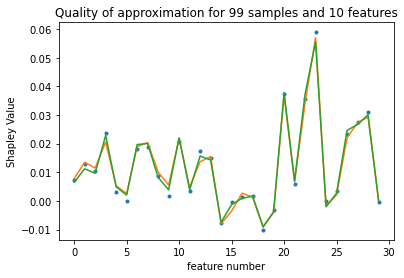

In [284]:
plt.plot(svs.T,".",label="KernelSHAP values for 2**N samples")
plt.xlabel("feature number")
plt.ylabel("Shapley Value")
plt.plot(np.mean(svs1,axis=0),label="KernelSHAP approximation")
plt.plot(np.mean(svs2,axis=0),label="my approximation")
plt.title("Quality of approximation for 99 samples and 10 features")
#plt.legend()

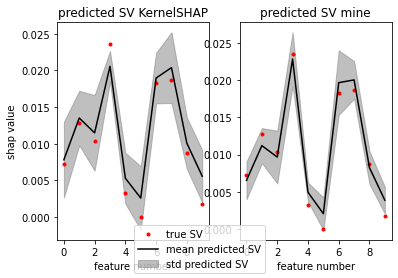

In [292]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(svs.T[:10],".r",label="true SV")
ax2.plot(svs.T[:10],".r")
ax1.plot(np.mean(svs1,axis=0)[:10],color='k',label="mean predicted SV")
ax2.plot(np.mean(svs2,axis=0)[:10],color='k')
ax1.fill_between(np.arange(n_dim)[:10],np.mean(svs1,axis=0)[:10] - np.std(svs1,axis=0)[:10],
                 np.mean(svs1,axis=0)[:10]+ np.std(svs1,axis=0)[:10],
                color='gray',alpha=0.5,label="std predicted SV")
ax2.fill_between(np.arange(n_dim)[:10],np.mean(svs2,axis=0)[:10] - np.std(svs2,axis=0)[:10],
                 np.mean(svs2,axis=0)[:10]+ np.std(svs2,axis=0)[:10],
                color='gray',alpha=0.5)
ax1.title.set_text("predicted SV KernelSHAP")
ax2.title.set_text("predicted SV mine")
ax1.set_xlabel("feature number")
ax2.set_xlabel("feature number")
ax1.set_ylabel("shap value")
#ax2.set_ylabel("shap value")
fig.legend(loc='lower center')

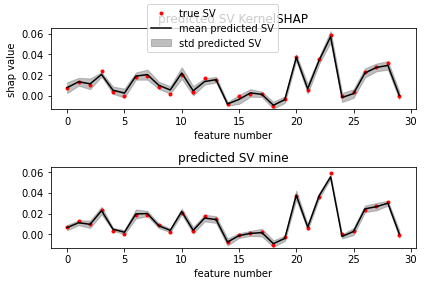

In [295]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(svs.T,".r",label="true SV")
ax2.plot(svs.T,".r")
ax1.plot(np.mean(svs1,axis=0),color='k',label="mean predicted SV")
ax2.plot(np.mean(svs2,axis=0),color='k')
ax1.fill_between(np.arange(n_dim),np.mean(svs1,axis=0)- np.std(svs1,axis=0),
                 np.mean(svs1,axis=0)+ np.std(svs1,axis=0),
                color='gray',alpha=0.5,label="std predicted SV")
ax2.fill_between(np.arange(n_dim),np.mean(svs2,axis=0) - np.std(svs2,axis=0),
                 np.mean(svs2,axis=0)+ np.std(svs2,axis=0),
                color='gray',alpha=0.5)
ax1.title.set_text("predicted SV KernelSHAP")
ax2.title.set_text("predicted SV mine")
ax1.set_xlabel("feature number")
ax2.set_xlabel("feature number")
ax1.set_ylabel("shap value")
ax1.set_ylim([-0.013,0.065])
ax2.set_ylim([-0.013,0.065])
#ax2.set_ylabel("shap value")
plt.tight_layout()
fig.legend(loc='upper center')

In [286]:
error_1 = 0 
error_2 = 0 
for sv1, sv2 in zip(svs1,svs2):
    error_1 += np.sum((sv1 - svs)**2)
    error_2 += np.sum((sv2 - svs)**2)
print(error_1)
print(error_2)

0.005550764055520671
0.0031382011310004242


In [63]:
# inspect the kernel weights and randomly selected samples 
print(explainer.kernelWeights[31])
print(explainer.maskMatrix[31, :])
print(explainer.kernelWeights[32])
print(explainer.maskMatrix[32, :])
print(explainer.kernelWeights[33])
print(explainer.maskMatrix[33, :])
print(0.7388/2048)
print("this means that this sample was probably only selected once, but there are samples that were selected multiple times")


0.002454762238743161
[0. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
0.002454762238743161
[1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
0.002454762238743161
[0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
0.0003607421875
this means that this sample was probably only selected once, but there are samples that were selected multiple times


In [290]:
### Now make the same plot for the in-built Shapley approximation
n_dim = 30
n_samples = 899
f = lambda x: model(Variable(torch.from_numpy(x).float())).detach().numpy()
explainer = Kernel(f,x[:,:n_dim])
sv = explainer.shap_values(instance_to_explain[:n_dim].detach().cpu().numpy(),kernelshap=True,nsamples=n_samples)

    
print(explainer.kernelWeights)


Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
[0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207 0.00435207
 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085

(899, 30)
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
[30 74 57 49 29 21 33 26 19 21 24 12 21 23 22 23 21 12 24 21 19 26 33 21
 29 48 57 74 30]
[0.00435207 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222 0.00085222
 0.00085222 0.00085222 0.00085222 0.00085222 0.00435207]


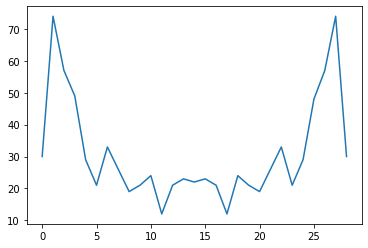

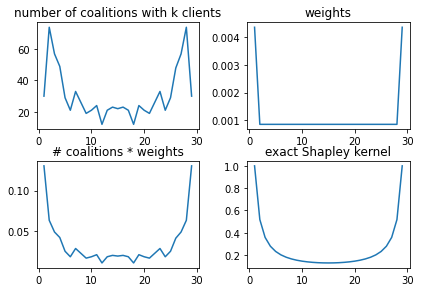

In [291]:
print(np.shape(explainer.maskMatrix))
occurrence = np.zeros(n_samples)
weights = np.zeros(n_clients-1)
for i,row in enumerate(explainer.maskMatrix):
    #print(np.sum(row))
    occurrence[i] = np.sum(row)
    weights[int(occurrence[i]-1)] = explainer.kernelWeights[i]
    #print(explainer.kernelWeights[i])
    
unique, counts = np.unique(occurrence, return_counts=True)
print(unique)
print(counts)
plt.plot(counts)
print(weights)

fig,ax = plt.subplots(2,2)
plt.tight_layout()
ax[0,0].plot(np.arange(1,n_clients),counts)
ax[0,0].title.set_text("number of coalitions with k clients")
ax[0,1].plot(np.arange(1,n_clients),weights)
ax[0,1].title.set_text("weights")
ax[1,0].plot(np.arange(1,n_clients),counts*weights)
ax[1,0].title.set_text("# coalitions * weights")
ax[1,1].plot(np.arange(1,n_clients),shap.shap_weights)
ax[1,1].title.set_text("exact Shapley kernel")